In [1]:
import time
import numpy as np
import typing
import pandas as pd

from src import numpy_pong
from src import vanilla_pong
from src import vectorized_envs

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
class BenchmarkResult(typing.NamedTuple):
    desc: str
    num_envs: int
    time_per_step_env: float

In [4]:
def sample_action(n):
    return np.random.choice(3, size=(n, 2))


def sample_atari_action(n):
    return np.random.choice([0,2,3], size=(n,))
    

def run_benchmark(envs, steps=100, sample_action=sample_action):
    # Warm up
    envs.reset()
    for _ in range(5):
        envs.step(sample_action(envs.n))

    start_time = time.time()

    envs.reset()
    for _ in range(steps):
        envs.step(sample_action(envs.n))
    end_time = time.time()
    delta = (end_time - start_time) / steps / envs.n
    return delta

# Load results

In [6]:
%store -r

## Rerun benchmarks

In [76]:
benchmarks = []

In [77]:
for n in [1, 4, 16, 64, 256, 1024, 4096, 16384]:
    time_per_step_env = run_benchmark(
        numpy_pong.BothPlayerPongGymEnv(numpy_pong.PongConfiguration(), n=n))
    benchmarks.append(
        BenchmarkResult(
            desc='numpy', num_envs=n, time_per_step_env=time_per_step_env))

In [78]:
for n in [1, 4, 16, 64, 256, 1024]:
    time_per_step_env = run_benchmark(
        vectorized_envs.SequentiallyVectorizedEnv([
            vanilla_pong.BothPlayerPongGymEnv(vanilla_pong.PongGame())
            for _ in range(n)
        ]))
    benchmarks.append(
        BenchmarkResult(
            desc='vanilla', num_envs=n, time_per_step_env=time_per_step_env))

In [ ]:
for n in [1, 4, 16, 64, 256, 1024]:
    time_per_step_env = run_benchmark(vectorized_envs.make_gym_sequential_envs('Pong-v0', n=n), sample_action=sample_atari_action)
    benchmarks.append(
        BenchmarkResult(
            desc='atari', num_envs=n, time_per_step_env=time_per_step_env))

In [83]:
%store benchmarks

Stored 'benchmarks' (list)


# Visualize results

In [9]:
dataframe = pd.DataFrame.from_records(benchmarks, columns=BenchmarkResult._fields).drop_duplicates(['desc', 'num_envs'], keep='last')

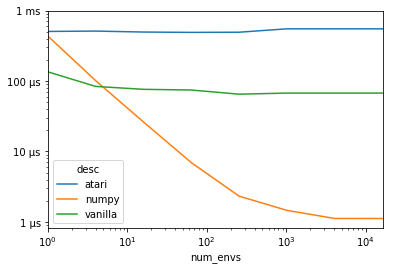

In [55]:
time_per_step_env=dataframe.pivot(index='num_envs',columns='desc',values='time_per_step_env')
time_per_step_env=time_per_step_env.ffill()
time_per_step_env.plot(logx=True, logy=True)
plt.yticks([10**-3, 10**-4, 10**-5, 10**-6], ['1 ms', '100 μs', '10 μs', '1 μs'])
plt.savefig('benchmark.png')

In [56]:
speedups = pd.DataFrame()
speedups['atari_vs_numpy']= time_per_step_env['atari']/time_per_step_env['numpy']
speedups['vanilla_vs_numpy']= time_per_step_env['vanilla']/time_per_step_env['numpy']
speedups

,atari_vs_numpy,vanilla_vs_numpy
num_envs,,
1,1.162346,0.310571
4,5.051870,0.828113
16,18.883153,2.904582
64,70.473163,10.721374
256,212.115408,27.992779
1024,377.105627,46.192200
4096,491.301512,60.180215
16384,491.928052,60.256961
